In [1]:
from matplotlib import pyplot as plt 

In [2]:
import json
from pprint import pprint

In [3]:
import json

In [4]:
import re

In [5]:
import numpy as np

In [6]:
def bucket(x, size):
    l = len(x)
    buckets = []
    i = 0
    while i < l:
        buckets.append(sum(x[i:i+size])/len(x[i:i+size]))
        i+=size
    return buckets

In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [8]:
class LogReader():
    def __init__(self, filename, keys):
        self.file = open(f'{filename}')
        self.keys = set(keys)
        self.matches = {}
        for key in keys:
            self.matches[key]=[]
    
    def grab(self):
        line = next(self.file, None)
        while line:
            split = line.strip().split('=')
            if len(split)==2:
                query = split[0]
                value = float(split[1])
                if query in self.keys:
                    self.matches[query].append(value)
            line = next(self.file, None)
        return self.matches

In [9]:
tasks = [
    ('atac_region', 'gene'),
    ('gene', 'atac_region'),
    ('gene', 'protein_name'),
    ('protein_name', 'gene'),
]

In [10]:
base_keys = [
    'train zero one loss',
    'train value loss',
    'train prediction loss',
    'validation zero one loss',
    'validation value loss',
    'validation prediction loss',
]

keys = []
for key in base_keys:
    for task in tasks:
        keys.append(f'{key} {task}')

In [11]:
keys += [
    'Outer step',
    'Batch'
]

In [12]:
readers = {}
matches = {}

#### Timestamp of run

In [15]:
timestamps = [
    '20211112-1558',
    '20211113-1207',
    '20211114-2216',
    
]
files = [f'logs/train_earl_{tmstp}.log' for tmstp in timestamps]

In [16]:
for file in files:
    if file not in readers:
        readers[file] = LogReader(file, keys)
        matches = readers[file].grab()

In [17]:
if True:
    for tmstp in timestamps:
        file = f'logs/train_earl_{tmstp}.log'
        matches = readers[file].grab()
        print(tmstp)
        for task in tasks:
            validation_losses = matches[f'validation prediction loss {task}']
            print(task, ' '.join([f'{loss:.3f}' for loss in validation_losses[-5:]]))
        print('----')

20211112-1558
('atac_region', 'gene') 0.460 0.388 0.441 0.396 0.411
('gene', 'atac_region') 0.303 0.276 0.281 0.351 0.303
('gene', 'protein_name') 0.583 0.639 0.493 0.462 0.384
('protein_name', 'gene') 0.503 0.329 0.541 0.466 0.299
----
20211113-1207
('atac_region', 'gene') 0.427 0.402 0.422 0.408 0.419
('gene', 'atac_region') 0.240 0.187 0.221 0.285 0.296
('gene', 'protein_name') 0.598 0.606 0.400 0.375 0.538
('protein_name', 'gene') 0.476 0.514 0.387 0.489 0.454
----
20211114-2216
('atac_region', 'gene') 14.246 0.402 0.373 0.404 0.424
('gene', 'atac_region') 0.388 0.304 0.294 0.274 0.313
('gene', 'protein_name') 8.837 0.548 0.927 0.571 0.676
('protein_name', 'gene') 1.977 0.414 0.349 0.465 0.541
----


## Select File

In [36]:
idx = 0

## Get matching log lines

In [37]:
file = files[idx]
matches = readers[file].grab()

## Parameters of this run

In [38]:
pprint(json.load(open(f'logs/earl_params_{timestamps[idx]}.json')))

{'atac_ones_weight': 1,
 'cells_per_batch': 10,
 'checkpoint': 25,
 'device': 'cuda:3',
 'gene_ones_weight': 1,
 'gnn_params': ['TransformerConv', {'heads': 1, 'out_channels': 128}],
 'lr': 0.001,
 'n_steps': 15000,
 'out_mlp': [128, 256, 1],
 'sample_depth': [3, 4, 5, 6],
 'sampling_factors': [1.4, 1.5, 1.6],
 'targets_per_sample': 1000,
 'train_batch_size': 5,
 'validation_batch_size': 10}


## Current Step

In [39]:
if len(matches['Outer step'])>0:
    batch = matches['Outer step'][-1]
    print(batch)
elif len(matches['Batch'])>0:
    epoch = matches['Batch'][-1]
    print(epoch)

2308.0


## Training loss

('atac_region', 'gene') 0.4790
('gene', 'atac_region') 0.2449
('gene', 'protein_name') 0.8059
('protein_name', 'gene') 0.4494


<Figure size 1080x720 with 0 Axes>

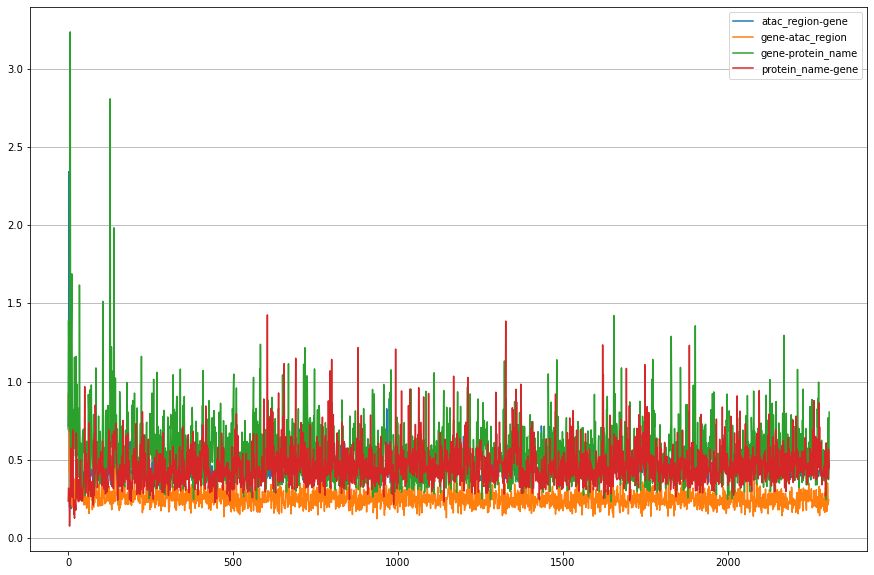

In [40]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(training_loss[0:], label=f'{task[0]}-{task[1]}')
    print(task, f'{training_loss[-1]:.4f}')
_=ax.legend()


('atac_region', 'gene') 0.47903365194797515
('gene', 'atac_region') 0.24492479860782623
('gene', 'protein_name') 0.805874589085579
('protein_name', 'gene') 0.44942307637797463


<Figure size 1080x720 with 0 Axes>

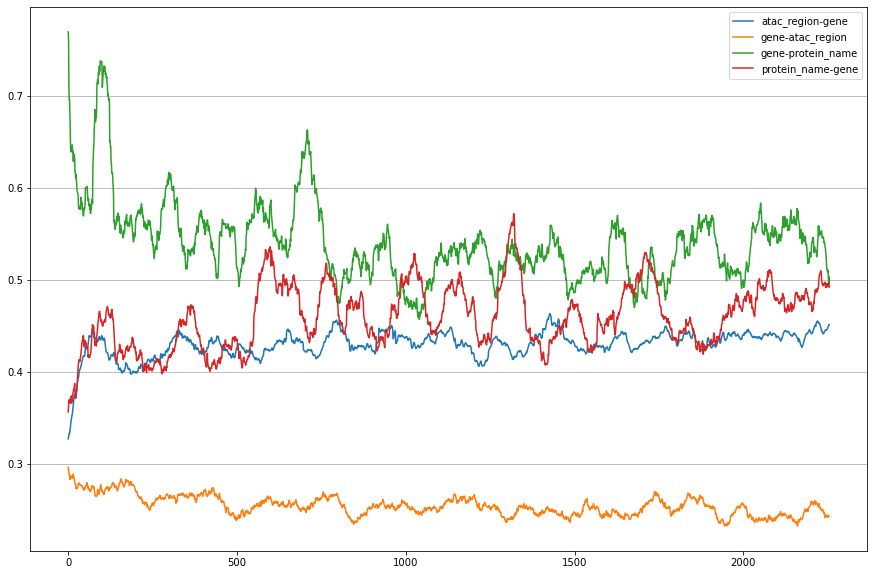

In [41]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(moving_average(training_loss[5:],50), label=f'{task[0]}-{task[1]}')
    print(task, training_loss[-1])
_=ax.legend()


## Validation Loss

('atac_region', 'gene') 0.41110509634017944
('gene', 'atac_region') 0.30284756496548654
('gene', 'protein_name') 0.3844433963298798
('protein_name', 'gene') 0.29948394894599917


<Figure size 1080x720 with 0 Axes>

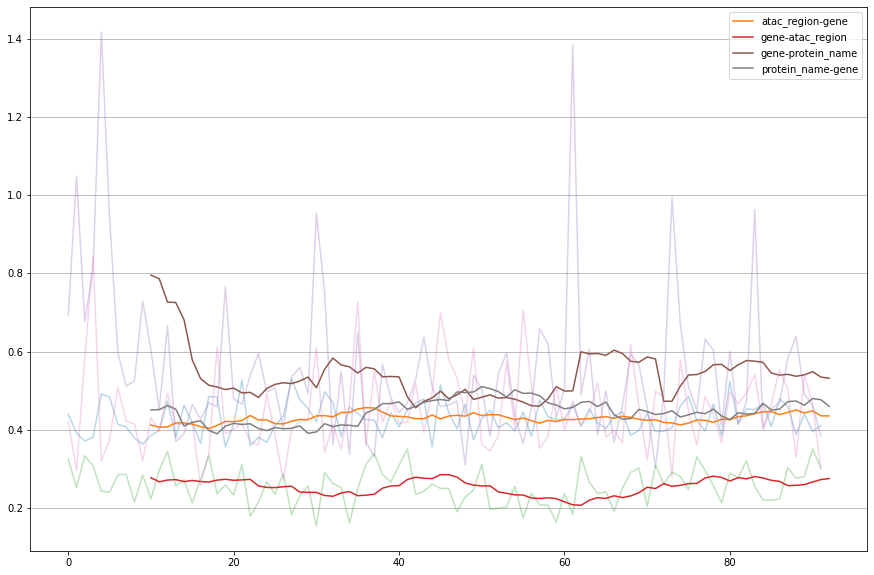

In [42]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

bucket=10

for task in tasks:
    validation_loss = matches[f'validation prediction loss {task}']
    _=ax.plot(validation_loss[1:], 
              alpha=.3)
    _=ax.plot(np.arange(bucket, len(validation_loss)),
              moving_average(validation_loss[1:],bucket), 
              label=f'{task[0]}-{task[1]}')
    print(task, validation_loss[-1])
    _=ax.legend()

## Sample predictions

In [43]:
import time

In [44]:
prediction_file = open(f'logs/train_earl_prediction_sample_{timestamps[idx]}.log')

for line in prediction_file:
    print(line.strip(), flush=True)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Task: ('protein_name', 'gene')
--------------------------------------------------------------------------------
batch 2300 0      pred,y:   0.000 0.000
batch 2300 1      pred,y:   0.000 0.000
batch 2300 2      pred,y:   1.164 0.000
batch 2300 3      pred,y:   0.000 0.000
batch 2300 4      pred,y:   0.000 0.000
batch 2300 5      pred,y:   0.000 0.000
batch 2300 6      pred,y:   0.000 0.000
batch 2300 7      pred,y:   0.843 0.000
batch 2300 8      pred,y:   0.000 0.000
batch 2300 9      pred,y:   0.000 0.000
batch 2300 10     pred,y:   0.000 0.000
batch 2300 11     pred,y:   0.000 0.000
batch 2300 12     pred,y:   0.000 0.900
batch 2300 13     pred,y:   0.000 0.000
batch 2300 14     pred,y:   0.808 0.000
batch 2300 15     pred,y:   0.000 0.900
batch 2300 16     pred,y:   0.000 0.000
batch 2300 17     pred,y:   1.164 0.000
batch 2300 18     pred,y:   0.000 0.900
batch 2300 19     pred,y:   0.000 0.000
batch 2300 20     pred,y:   0.000 1.366
batch 2300 21     pred,y:   0.000 0.000
batch 23

batch 2300 47     pred,y:   0.000 0.000
batch 2300 48     pred,y:   0.000 0.000
batch 2300 49     pred,y:   0.000 0.000
batch 2300 50     pred,y:   0.000 0.000
batch 2300 51     pred,y:   0.000 0.000
batch 2300 52     pred,y:   0.000 0.000
batch 2300 53     pred,y:   0.000 0.000
batch 2300 54     pred,y:   0.000 0.915
batch 2300 55     pred,y:   0.000 0.000
batch 2300 56     pred,y:   0.000 0.000
batch 2300 57     pred,y:   1.248 0.000
batch 2300 58     pred,y:   0.000 0.000
batch 2300 59     pred,y:   0.000 0.000
batch 2300 60     pred,y:   0.000 0.000
batch 2300 61     pred,y:   0.000 0.000
batch 2300 62     pred,y:   0.000 0.000
batch 2300 63     pred,y:   0.000 0.915
batch 2300 64     pred,y:   0.000 0.000
batch 2300 65     pred,y:   0.000 0.000
batch 2300 66     pred,y:   0.000 0.915
batch 2300 67     pred,y:   0.000 0.915
batch 2300 68     pred,y:   0.000 0.000
batch 2300 69     pred,y:   0.000 0.000
batch 2300 70     pred,y:   1.273 0.000
batch 2300 71     pred,y:   1.907 0.915


batch 2300 48     pred,y:   1.014 0.000
batch 2300 49     pred,y:   1.016 0.000
batch 2300 50     pred,y:   1.188 0.000
batch 2300 51     pred,y:   0.000 0.000
batch 2300 52     pred,y:   0.000 0.000
batch 2300 53     pred,y:   0.000 0.000
batch 2300 54     pred,y:   0.000 0.000
batch 2300 55     pred,y:   0.000 1.308
batch 2300 56     pred,y:   0.000 0.000
batch 2300 57     pred,y:   0.804 0.000
batch 2300 58     pred,y:   0.000 0.641
batch 2300 59     pred,y:   0.000 0.000
batch 2300 60     pred,y:   1.132 0.000
batch 2300 61     pred,y:   0.000 0.000
batch 2300 62     pred,y:   1.035 0.000
batch 2300 63     pred,y:   0.000 0.000
batch 2300 64     pred,y:   0.878 0.000
batch 2300 65     pred,y:   0.000 0.000
batch 2300 66     pred,y:   0.000 0.000
batch 2300 67     pred,y:   0.000 0.000
batch 2300 68     pred,y:   0.000 0.000
batch 2300 69     pred,y:   0.000 0.000
batch 2300 70     pred,y:   0.000 0.000
batch 2300 71     pred,y:   0.926 0.000
batch 2300 72     pred,y:   1.121 1.308


batch 2300 8      pred,y:   0.729 0.234
batch 2300 9      pred,y:   0.881 0.505
batch 2300 10     pred,y:   0.850 3.345
batch 2300 0      pred,y:   0.686 0.900
batch 2300 1      pred,y:   0.000 2.116
batch 2300 2      pred,y:   0.825 1.497
batch 2300 3      pred,y:   0.975 0.900
batch 2300 4      pred,y:   0.968 1.497
batch 2300 5      pred,y:   1.328 1.748
batch 2300 6      pred,y:   0.817 0.437
batch 2300 7      pred,y:   0.000 0.000
batch 2300 8      pred,y:   0.672 1.974
batch 2300 9      pred,y:   1.979 1.101
batch 2300 10     pred,y:   0.738 0.311
batch 2300 11     pred,y:   0.813 0.168
batch 2300 12     pred,y:   0.000 1.268
batch 2300 13     pred,y:   0.731 0.437
batch 2300 14     pred,y:   1.593 0.648
batch 2300 15     pred,y:   0.737 0.311
batch 2300 16     pred,y:   0.736 0.548
batch 2300 17     pred,y:   1.011 1.038
batch 2300 0      pred,y:   0.706 0.219
batch 2300 1      pred,y:   0.675 0.000
batch 2300 2      pred,y:   0.855 0.550
batch 2300 3      pred,y:   0.000 0.799


batch 2300 67     pred,y:   0.000 0.000
batch 2300 68     pred,y:   1.345 0.000
batch 2300 69     pred,y:   0.000 0.000
batch 2300 70     pred,y:   0.000 0.000
batch 2300 71     pred,y:   0.000 0.000
batch 2300 72     pred,y:   1.345 0.000
batch 2300 73     pred,y:   0.000 0.000
batch 2300 74     pred,y:   0.000 0.000
batch 2300 75     pred,y:   0.000 0.000
batch 2300 76     pred,y:   0.000 0.000
batch 2300 77     pred,y:   0.000 0.000
batch 2300 78     pred,y:   0.000 0.000
batch 2300 79     pred,y:   0.000 0.000
batch 2300 80     pred,y:   1.314 0.000
batch 2300 81     pred,y:   0.000 0.000
batch 2300 82     pred,y:   0.000 0.000
batch 2300 83     pred,y:   0.000 0.000
batch 2300 84     pred,y:   0.000 0.000
batch 2300 85     pred,y:   0.000 0.000
batch 2300 86     pred,y:   1.258 0.000
batch 2300 87     pred,y:   0.000 0.000
batch 2300 88     pred,y:   0.000 0.000
batch 2300 89     pred,y:   1.292 0.000
batch 2300 90     pred,y:   0.000 0.000
batch 2300 91     pred,y:   0.000 0.000


batch 2300 72     pred,y:   0.000 0.000
batch 2300 73     pred,y:   1.330 0.000
batch 2300 74     pred,y:   0.000 0.000
batch 2300 75     pred,y:   0.000 0.000
batch 2300 76     pred,y:   0.000 0.000
batch 2300 77     pred,y:   0.000 0.000
batch 2300 78     pred,y:   1.146 0.000
batch 2300 79     pred,y:   0.000 0.524
batch 2300 80     pred,y:   1.294 1.492
batch 2300 81     pred,y:   0.000 0.000
batch 2300 82     pred,y:   0.000 0.000
batch 2300 83     pred,y:   0.000 0.000
batch 2300 84     pred,y:   0.000 0.524
batch 2300 85     pred,y:   0.000 0.000
batch 2300 86     pred,y:   0.000 0.000
batch 2300 87     pred,y:   0.000 0.000
batch 2300 88     pred,y:   0.000 0.000
batch 2300 89     pred,y:   0.000 0.000
batch 2300 90     pred,y:   0.000 0.524
batch 2300 91     pred,y:   0.000 2.298
batch 2300 92     pred,y:   1.290 0.524
batch 2300 93     pred,y:   0.000 0.000
batch 2300 94     pred,y:   0.000 0.000
batch 2300 95     pred,y:   0.000 0.000
batch 2300 96     pred,y:   0.000 0.000


batch 2300 77     pred,y:   0.000 0.000
batch 2300 78     pred,y:   0.000 0.000
batch 2300 79     pred,y:   0.000 0.000
batch 2300 80     pred,y:   0.000 0.000
batch 2300 81     pred,y:   0.000 0.000
batch 2300 82     pred,y:   1.347 0.000
batch 2300 83     pred,y:   0.000 0.000
batch 2300 84     pred,y:   0.000 0.000
batch 2300 85     pred,y:   0.000 0.000
batch 2300 86     pred,y:   0.000 0.000
batch 2300 87     pred,y:   0.000 0.000
batch 2300 88     pred,y:   0.000 0.000
batch 2300 89     pred,y:   1.277 0.000
batch 2300 90     pred,y:   0.000 2.469
batch 2300 91     pred,y:   0.000 0.000
batch 2300 92     pred,y:   0.000 0.000
batch 2300 93     pred,y:   0.000 0.000
batch 2300 94     pred,y:   0.000 0.000
batch 2300 95     pred,y:   0.000 0.000
batch 2300 96     pred,y:   1.367 1.857
batch 2300 97     pred,y:   0.000 0.000
batch 2300 98     pred,y:   0.000 0.000
batch 2300 99     pred,y:   1.304 0.000
batch 2300 0      pred,y:   0.000 0.000
batch 2300 1      pred,y:   1.251 1.500


batch 2300 82     pred,y:   0.000 0.000
batch 2300 83     pred,y:   0.000 0.000
batch 2300 84     pred,y:   0.000 0.000
batch 2300 85     pred,y:   0.000 0.000
batch 2300 86     pred,y:   0.000 0.000
batch 2300 87     pred,y:   1.290 0.000
batch 2300 88     pred,y:   0.000 0.000
batch 2300 89     pred,y:   1.083 0.000
batch 2300 90     pred,y:   0.000 0.000
batch 2300 91     pred,y:   0.000 0.000
batch 2300 92     pred,y:   1.259 0.000
batch 2300 93     pred,y:   0.000 0.000
batch 2300 94     pred,y:   0.000 0.000
batch 2300 95     pred,y:   0.000 0.000
batch 2300 96     pred,y:   0.000 0.000
batch 2300 97     pred,y:   0.000 0.000
batch 2300 98     pred,y:   0.000 0.000
batch 2300 99     pred,y:   1.267 0.000
batch 2300 0      pred,y:   0.000 0.000
batch 2300 1      pred,y:   0.000 0.000
batch 2300 2      pred,y:   0.000 0.000
batch 2300 3      pred,y:   0.000 0.000
batch 2300 4      pred,y:   0.000 0.000
batch 2300 5      pred,y:   0.000 0.000
batch 2300 6      pred,y:   0.000 0.000


batch 2300 87     pred,y:   0.000 0.000
batch 2300 88     pred,y:   0.000 0.000
batch 2300 89     pred,y:   0.000 0.000
batch 2300 90     pred,y:   0.000 0.000
batch 2300 91     pred,y:   1.277 1.742
batch 2300 92     pred,y:   0.000 0.000
batch 2300 93     pred,y:   1.978 0.000
batch 2300 94     pred,y:   0.000 0.000
batch 2300 95     pred,y:   1.346 1.210
batch 2300 96     pred,y:   0.000 1.210
batch 2300 97     pred,y:   0.000 0.000
batch 2300 98     pred,y:   0.000 0.000
batch 2300 99     pred,y:   1.319 0.000
batch 2300 0      pred,y:   0.000 0.000
batch 2300 1      pred,y:   0.000 0.000
batch 2300 2      pred,y:   0.000 0.000
batch 2300 3      pred,y:   1.293 0.000
batch 2300 4      pred,y:   0.000 0.738
batch 2300 5      pred,y:   1.188 0.000
batch 2300 6      pred,y:   0.000 0.738
batch 2300 7      pred,y:   1.382 0.000
batch 2300 8      pred,y:   0.000 0.000
batch 2300 9      pred,y:   0.000 0.000
batch 2300 10     pred,y:   0.000 0.000
batch 2300 11     pred,y:   0.000 0.000


batch 2300 88     pred,y:   0.054 0.000
batch 2300 89     pred,y:   0.043 0.000
batch 2300 90     pred,y:   0.036 0.000
batch 2300 91     pred,y:   0.075 0.000
batch 2300 92     pred,y:   0.039 0.000
batch 2300 93     pred,y:   0.029 0.000
batch 2300 94     pred,y:   0.043 0.000
batch 2300 95     pred,y:   0.054 0.000
batch 2300 96     pred,y:   0.053 0.000
batch 2300 97     pred,y:   0.099 0.000
batch 2300 98     pred,y:   0.052 0.000
batch 2300 99     pred,y:   0.069 0.000
batch 2300 0      pred,y:   0.046 0.000
batch 2300 1      pred,y:   0.103 0.000
batch 2300 2      pred,y:   0.043 0.000
batch 2300 3      pred,y:   0.052 0.000
batch 2300 4      pred,y:   0.120 0.000
batch 2300 5      pred,y:   0.044 0.000
batch 2300 6      pred,y:   0.068 0.000
batch 2300 7      pred,y:   0.116 0.000
batch 2300 8      pred,y:   0.052 0.000
batch 2300 9      pred,y:   0.049 0.000
batch 2300 10     pred,y:   0.045 0.000
batch 2300 11     pred,y:   0.034 0.000
batch 2300 12     pred,y:   0.045 1.000


batch 2300 93     pred,y:   0.045 0.000
batch 2300 94     pred,y:   0.221 0.000
batch 2300 95     pred,y:   0.061 0.000
batch 2300 96     pred,y:   0.060 0.000
batch 2300 97     pred,y:   0.048 0.000
batch 2300 98     pred,y:   0.044 0.000
batch 2300 99     pred,y:   0.118 0.000
batch 2300 0      pred,y:   0.048 0.000
batch 2300 1      pred,y:   0.044 0.000
batch 2300 2      pred,y:   0.040 0.000
batch 2300 3      pred,y:   0.050 0.000
batch 2300 4      pred,y:   0.043 0.000
batch 2300 5      pred,y:   0.020 0.000
batch 2300 6      pred,y:   0.054 0.000
batch 2300 7      pred,y:   0.045 0.000
batch 2300 8      pred,y:   0.042 0.000
batch 2300 9      pred,y:   0.048 0.000
batch 2300 10     pred,y:   0.095 0.000
batch 2300 11     pred,y:   0.029 0.000
batch 2300 12     pred,y:   0.101 0.000
batch 2300 13     pred,y:   0.040 0.000
batch 2300 14     pred,y:   0.055 0.000
batch 2300 15     pred,y:   0.036 0.000
batch 2300 16     pred,y:   0.271 0.000
batch 2300 17     pred,y:   0.048 0.000


batch 2300 41     pred,y:   0.054 0.000
batch 2300 42     pred,y:   0.034 0.000
batch 2300 43     pred,y:   0.075 0.000
batch 2300 44     pred,y:   0.102 0.000
batch 2300 45     pred,y:   0.062 0.000
batch 2300 46     pred,y:   0.038 0.000
batch 2300 47     pred,y:   0.071 0.000
batch 2300 48     pred,y:   0.021 0.000
batch 2300 49     pred,y:   0.056 0.000
batch 2300 50     pred,y:   0.056 0.000
batch 2300 51     pred,y:   0.048 0.000
batch 2300 52     pred,y:   0.031 0.000
batch 2300 53     pred,y:   0.043 0.000
batch 2300 54     pred,y:   0.033 0.000
batch 2300 55     pred,y:   0.033 0.000
batch 2300 56     pred,y:   0.048 0.000
batch 2300 57     pred,y:   0.063 0.000
batch 2300 58     pred,y:   0.029 0.000
batch 2300 59     pred,y:   0.091 0.000
batch 2300 60     pred,y:   0.038 0.000
batch 2300 61     pred,y:   0.041 0.000
batch 2300 62     pred,y:   0.043 0.000
batch 2300 63     pred,y:   0.038 0.000
batch 2300 64     pred,y:   0.045 0.000
batch 2300 65     pred,y:   0.038 0.000


batch 2300 86     pred,y:   0.043 0.000
batch 2300 87     pred,y:   0.057 0.000
batch 2300 88     pred,y:   0.061 0.000
batch 2300 89     pred,y:   0.069 0.000
batch 2300 90     pred,y:   0.047 0.000
batch 2300 91     pred,y:   0.012 0.000
batch 2300 92     pred,y:   0.045 0.000
batch 2300 93     pred,y:   0.053 0.000
batch 2300 94     pred,y:   0.046 0.000
batch 2300 95     pred,y:   0.043 0.000
batch 2300 96     pred,y:   0.058 0.000
batch 2300 97     pred,y:   0.044 0.000
batch 2300 98     pred,y:   0.046 0.000
batch 2300 99     pred,y:   0.045 0.000
batch 2300 0      pred,y:   0.038 0.000
batch 2300 1      pred,y:   0.039 0.000
batch 2300 2      pred,y:   0.028 0.000
batch 2300 3      pred,y:   0.040 0.000
batch 2300 4      pred,y:   0.045 0.000
batch 2300 5      pred,y:   0.035 0.000
batch 2300 6      pred,y:   0.031 0.000
batch 2300 7      pred,y:   0.045 0.000
batch 2300 8      pred,y:   0.039 0.000
batch 2300 9      pred,y:   0.048 0.000
batch 2300 10     pred,y:   0.044 0.000
